# Odds and Ends in Protein Electrostatics 
_Stefan Hervø-Hansen, Division of Theoretical Chemistry, Lund University._

This notebook is a continuation of intresting topics within protein electrostatics. Topics include the EXG protein and protein engineering in colaboration with Jakob Winther, and topics mentioned at the protein electrostatics meeting 2019 in Telluride, Colorado, USA.


## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
import mdtraj as md
from scipy import stats
from adjustText import adjust_text
from simtk.openmm import app
import simtk.openmm as mm
import openmmtools as mmtools
import parmed as pmd


%matplotlib inline

## Energetics of Ion Pairs in Different Dielectrics
This is a very primative model (Coulomb and Born), which predicts the unfavorable process of transfering an ionpair from a high dielectric to a low dielectric.
### Solvation and Electrostatic Energy Function

In [3]:
def BornEnergy(Q, r0, eps=80):
    '''
    Calculates the Born energy of a single ion.
    
    Parameters
    ----------
    Q: float, charge of ion in elementary charges.
    r0: float, radius of ion in angstrøm.
    eps: float, unitless dielectric constant (default: 80).
    
    Example
    ----------
    SolvationEnergy = BornEnergy(-1, 1.75, 50)
    '''
    k = 1.38935406579333*10**(-4) / 2 # [m^2*N/(e^2*mol)], k = Na/(8*pi*epsilon)
    r0 *= 10**(-10)
    return (-k*Q**2/r0) * (1/80 - 1/eps)

def CoulombEnergy(Q1, Q2, r, eps=80):
    '''
    Calculates the Coulomb energy between two ions.
    
    Parameters
    ----------
    Q1: float, charge of ion 1 in elementary charges.
    Q2: float, charge of ion 2 in elementary charges.
    r: float, distance between ion 1 and 2 in angstrøm.
    eps: float, unitless dielectric constant (default: 80).
    
    Example
    ----------
    ElectrostaticEnergy = CoulombEnergy(-1, 1, 3.5, 50)
    '''
    r *= 10**(-10)
    k = 1.38935406579333*10**(-4) #  [m^2*N/(e^2*mol)], k = Na/(4*pi*epsilon)
    return k*(Q1*Q2/(r*eps))


### Do the Calculations

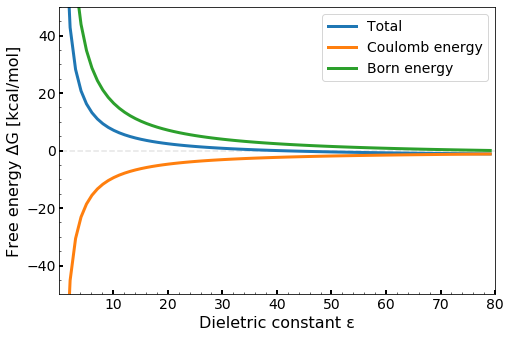

In [35]:
eps_list = np.arange(0.1, 80, 1)
Energy = {
    'Born': [],
    'Coulomb': [],
    'Total': []
}

for eps in eps_list:
    unit_Joule_to_kcal = 2.39*10**(-4)
    E_Coulomb = CoulombEnergy(Q1=1, Q2=-1, r=3.5, eps=eps) * unit_Joule_to_kcal
    E_Born = BornEnergy(Q=1, r0=1.75, eps=eps) * 2 * unit_Joule_to_kcal
    E_Total = E_Coulomb + E_Born
    
    Energy['Coulomb'].append(E_Coulomb)
    Energy['Born'].append(E_Born)
    Energy['Total'].append(E_Total)
    

# Plotting.
fig, ax = plt.subplots(figsize=(6*1.2,4*1.2))

ax.plot(eps_list, Energy['Total'], label='Total', linewidth=3)
ax.plot(eps_list, Energy['Coulomb'], label='Coulomb energy', linewidth=3)
ax.plot(eps_list, Energy['Born'], label='Born energy',  linewidth=3)
ax.hlines(0, -100, 100, alpha=0.1, linestyle='dashed')

# Graphical settings.
ax.minorticks_on()
ax.set_ylim(-50, 50)
ax.set_xlim(0.1, 80)
ax.legend(loc=0, fontsize=14)
ax.set_xlabel('Dieletric constant ε', fontsize=16)
ax.set_ylabel('Free energy ΔG [kcal/mol]', fontsize=16)
ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize=14)
ax.tick_params(which='both', direction='in')

fig.tight_layout()
fig.savefig("Solvation_of_ionpair.pdf")

## Diprotic acid model: Salt bridge vs Hydrogen bond
The protonation states has been measured for an Asp-His pair in the EXG protein using Monte Carlo simulations. The population of each protonation state as a function of pH is here visaulized.

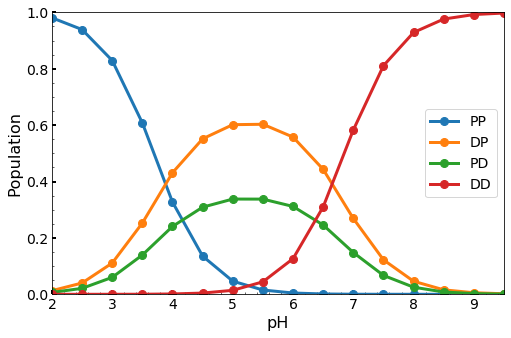

In [31]:
# Load diprotic acid population data
pH, PD, PP, DP, DD = np.loadtxt('Diprotic_population_EXG_39D66H.dat', usecols=[0,1,2,3,4], unpack=True, skiprows=1)

# Plotting
fig, ax = plt.subplots(figsize=(6*1.2, 4*1.2))

ax.plot(pH, PP, label='PP', marker='o', markersize=8, linewidth=3)
ax.plot(pH, DP, label='DP', marker='o', markersize=8, linewidth=3)
ax.plot(pH, PD, label='PD', marker='o', markersize=8, linewidth=3)
ax.plot(pH, DD, label='DD', marker='o', markersize=8, linewidth=3)

def QPD(x,k):
    return 10.**(k[0] - x)
def QDP(x,k)
    return 10.**(k[1] - x)
def QPP(x,k):
    return 10.**((k[0] - k[2] - k[3]) - 2*x)
def QDD(x,k):
    return 1





QPD = @(x,k) 10.^( k(1) - x );                        % k(1) = pKa_39^57D
QDP = @(x,k) 10.^( k(2) - x );                        % k(2) = pKa_57^39D
QPP = @(x,k) 10.^( (k(1) + k(2) - k(3)) - 2*x);       % NOTE k(3)=W
QDD = @(x,k) 1;     
# add fitting
# change legend, to +- 00 +0 -0

# Graphical settings
ax.minorticks_on()
ax.set_ylim(0, 1)
ax.set_xlim(min(pH), max(pH))
ax.legend(loc=0, fontsize=14)
ax.set_xlabel('pH', fontsize=16)
ax.set_ylabel('Population', fontsize=16)
ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize=14)
ax.tick_params(which='minor', direction='in')

fig.tight_layout()
fig.savefig("Diprotic_microstate_population.pdf")

## Diprotic acid: pH-dependent distance distribution
The distance between the titratable sites of the 39D-66H EXG variant has been obtained from the molecular dynamics simulations at different pH. The distrubtions are visualized here.

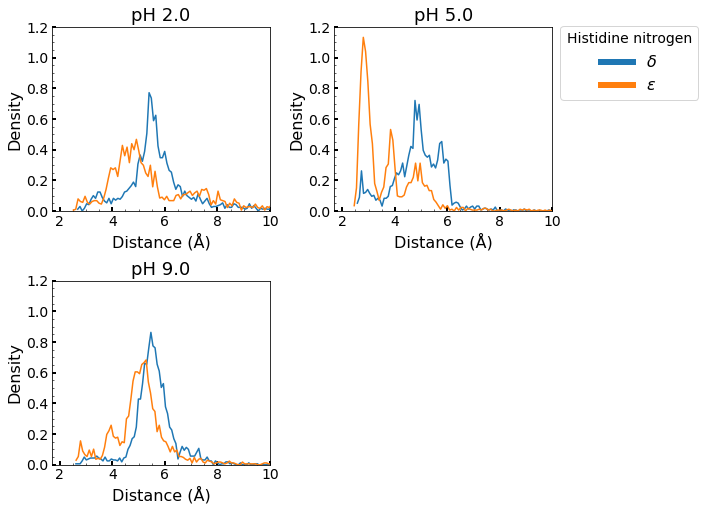

In [4]:
# pH values for which trajectories exists
pHs = [2, 5, 9]

# Initiate figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(1.5*5.5*1.2, 1.5*4*1.2))
axes = [item for sublist in axes for item in sublist]

for i, pH in enumerate(pHs):
    # Load trajecotry
    traj = md.load('trajectories/EXG_39D66H_pH{}.pdb'.format(pH))
    
    coc_dN_dist = []
    coc_eN_dist = []
    
    # Getting index for the indivudal atoms
    asp_oxy = traj.topology.select('(resname AS4 and name OD1) || (resname AS4 and name OD2)') # Aspratate side chain carboxyl oxygen
    his_dN  = traj.topology.select('resname HIS and name ND1') # Histidine side chain imidazole delta nitrogen
    his_eN  = traj.topology.select('resname HIS and name NE2') # Histidine side chain imidazole epsilon nitrogen
    
    for frame in range(traj.n_frames):
        # Calculate center of charge
        coc = (traj.xyz[frame][asp_oxy[0]] + traj.xyz[frame][asp_oxy[1]]) / 2
        
        # Append calculated distances to list
        coc_dN_dist.append(10*np.linalg.norm(coc - traj.xyz[frame][his_dN]))
        coc_eN_dist.append(10*np.linalg.norm(coc - traj.xyz[frame][his_eN]))
     
    for j, distance in enumerate([coc_dN_dist, coc_eN_dist]):
        # Create histogram and plot
        dist_probability, bin_edges_dist = np.histogram(distance, bins=100, density=True)
        bin_centers = (bin_edges_dist[:-1] + bin_edges_dist[1:]) / 2.
        
        if j == 0:
            label = '$\delta$'
        elif j == 1:
            label = '$\epsilon$'
        axes[i].plot(bin_centers, dist_probability, label=label)
        
    axes[i].set_xlim(1.7, 10.0)
    axes[i].set_ylim(0.0, 1.2)
    axes[i].minorticks_on()
    axes[i].set_title('pH {:.1f}'.format(pH), fontsize=18)
    axes[i].set_xlabel('Distance (Å)', fontsize=16)
    axes[i].set_ylabel('Density', fontsize=16)
    #axes[i].legend(loc='upper right', title='Histidine nitrogen', fontsize=14)
    axes[i].tick_params(which='major', direction='in', length=4, width=2, colors='black',
                   grid_color='black', grid_alpha=0.5, labelsize=14)
    axes[i].tick_params(which='minor', direction='in')

# Legend
leg = axes[1].legend(loc='upper left', title='Histidine nitrogen', fontsize=16, bbox_to_anchor=(1.0, 1.05))
for line in leg.get_lines():
    line.set_linewidth(6.0)
leg.get_title().set_fontsize(14)

# Image for 4. graph
#img = mpimg.imread('trajectories/Asp_His_pair_v1_1.png')
#imgplot = axes[3].imshow(img, interpolation='none')
axes[3].axis('off')

# Save figure
fig.tight_layout()
#fig.savefig('Distance_distribution_manual.png', dpi=600)

## pKa Prediction of Titratable Residues in a Highly Charge-depleated Protein
Total correlation plot between predicted pKa values by CpHMD simulation and experimental pKa values by NMR spectroscopy for the EXG system.

In [4]:
#### EXG DATA ####

# Experimental pka values
Asp39  = 5
Asp43  = 4.37
Asp61  = 4.15
Asp39d = 4.07
Asp43d = 4.32
Asp61d = 4.1

His66  = 6.39
His66d39 = 7.24
His66d43 = 6.49 
His66d61 = 6.68

exp_asp = [Asp39, Asp43, Asp61, Asp39d, Asp43d, Asp61d]
exp_his = [His66, His66d39, His66d43, His66d61]

# Predicted pka values
sim_Asp39 = 5.33
sim_Asp43 = 4.78
sim_Asp61 = 4.49
sim_Asp39d= 3.69
sim_Asp43d= 4.66
sim_Asp61d= 4.19

sim_His66 = 6.1
sim_His66d39 = 6.85
sim_His66d43 = 6.01
sim_His66d61 = 6.07

sim_asp = [sim_Asp39, sim_Asp43, sim_Asp61, sim_Asp39d, sim_Asp43d, sim_Asp61d]
sim_his = [sim_His66, sim_His66d39, sim_His66d43, sim_His66d61]


label_asp = ['D39', 'D43', 'D61', 'H66-D39', 'H66-D43', 'H66-D61']
label_his = ['H66', 'H66-D39', 'H66-D43', 'H66-D61']

slope: 1.204133317301808
intercept: -1.0009635163635329
r_value**2: 0.9257400134530535
Root-mean-square error (RMSE) of pKa values: 0.38722086720630133


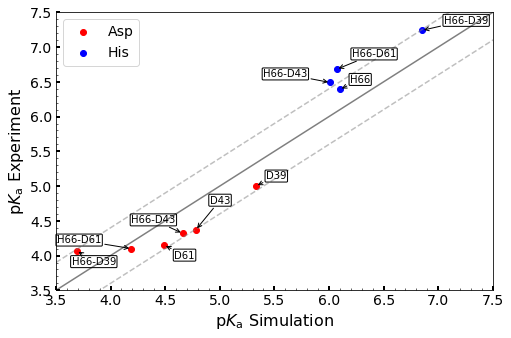

In [7]:
# Begin figure
fig, ax = plt.subplots(figsize=(6*1.2, 4*1.2))

texts = []

# Plot
ax.scatter(sim_asp, exp_asp, color='red', label='Asp')
ax.scatter(sim_his, exp_his, color='blue', label='His')

for i, txt in enumerate(label_asp):
    if i > 2:
        weight = 'normal'
    else:
        weight = 'normal'
    text = ax.annotate(txt, (sim_asp[i], exp_asp[i]), weight=weight,
                       bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.1'))
    texts.append(text)
    
for i, txt in enumerate(label_his):
    text = ax.annotate(txt, (sim_his[i], exp_his[i]),
                       bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.1'))
    texts.append(text)


# Statistics and Regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(sim_asp+sim_his,exp_asp+exp_his)
f = lambda x: slope*x + intercept
g = lambda x: x
x = np.array([3.5,10])
#ax.plot(x, f(x), label='Linear fit')
ax.plot(x, g(x), color='black', alpha=0.5)
ax.plot(x, g(x)+0.4, color='gray', alpha=0.5, linestyle='dashed')
ax.plot(x, g(x)-0.4, color='gray', alpha=0.5, linestyle='dashed')

# Axis modification
ax.set_xlim(3.5,7.5)
ax.set_ylim(3.5,7.5)
ax.minorticks_on()
ax.legend(loc=0, fontsize=14)
ax.set_xlabel(r'p$K_{\mathrm{a}}$ Simulation', fontsize=16)
ax.set_ylabel(r'p$K_{\mathrm{a}}$ Experiment', fontsize=16)
ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize=14)
ax.tick_params(which='minor', direction='in')

fig.tight_layout()
# Avoid overlapping annotations
adjust_text(texts, expand_points=(2.0,2.0), expand_text=(2.0, 2.0), arrowprops=dict(arrowstyle='->', color='black')) # 1.3,1.3
fig.savefig('Total_pka_correlation.pdf')

print('slope: {}'.format(slope))
print('intercept: {}'.format(intercept))
print('r_value**2: {}'.format(r_value**2))

sim_full = np.append(sim_asp, sim_his)
exp_full = np.append(exp_asp, exp_his)


pKa_RMSD = np.sqrt(np.sum(np.subtract(sim_full,exp_full)**2)/len(exp_full))
print(r'Root-mean-square error (RMSE) of pKa values: {}'.format(pKa_RMSD))

## Alchemical Transformation of Salt-bridge to Hydrogen-bond

In [2]:
factory = mmtools.alchemy.AbsoluteAlchemicalFactory(consistent_exceptions=False)

In [6]:
EXG_hb = pmd.load_file('proton_transfer/EXG_39D66H_hb.parm7', 'proton_transfer/EXG_39D66H_hb.rst7')
EXG_hb_system = EXG_hb.createSystem(nonbondedMethod=app.PME, ewaldErrorTolerance=0.00001,
                                       nonbondedCutoff=1.2*pmd.unit.nanometers, constraints=app.HBonds)